In [1]:
from functools import partial

import lightgbm
import matplotlib.pyplot as plt
import numpy as np
import sklearn, sklearn.linear_model

import loader
from models import BinningCalibrator
import utils

split_ratio_test = 0.3
split_ratio_postproc = 0.5  # among all training data

# These seeds control the randomness for the post-process/test split and in
# postprocessing.  It does not affect pre-training data nor the randomness in
# pre-training, i.e., we assume the pre-trained predictor to be fixed.  Results
# will be aggregated over the seeds.
seeds = range(33, 38)

# This seed controls the randomness during pre-training (fixed)
seed_pretrain = 33

# Settings for calibration
n_bins_calib = 40
prior_strength_calib = 1
calibrator_factory = partial(BinningCalibrator,
                             n_bins=n_bins_calib,
                             prior_strength=prior_strength_calib)

max_workers = 32

data_dir = "data/adult"

In [2]:
## Load UCI Adult dataset

(inputs_df, labels, label_names, groups,
 group_names) = loader.load_adult(data_dir)
inputs_u_df = loader.load_adult(data_dir, remove_sensitive_attr=True)[0]
      
display(loader.dataset_stats(labels, label_names, groups, group_names))

n_classes = len(label_names)
n_groups = len(group_names)

inputs = np.array(inputs_df.values, dtype=np.float32)
inputs_u = np.array(inputs_u_df.values, dtype=np.float32)

Group,Female,Male
Target,,
<=50K,14423,22732
>50K,1769,9918


In [3]:
## Split data into (test + post-processing) and pre-training sets

(inputs_, inputs_pretrain, inputs_u_, inputs_u_pretrain, labels_,
 labels_pretrain, groups_,
 groups_pretrain) = sklearn.model_selection.train_test_split(
     inputs,
     inputs_u,
     labels,
     groups,
     test_size=(1 - split_ratio_test) * (1 - split_ratio_postproc),
     random_state=seed_pretrain,
 )

# Encode the joint (A, Y) labels by flattening
labels_ay_pretrain = groups_pretrain * n_classes + labels_pretrain

# Normalize data
scaler = sklearn.preprocessing.StandardScaler()
inputs_pretrain = scaler.fit_transform(inputs_pretrain)
inputs_ = scaler.transform(inputs_)

scaler = sklearn.preprocessing.StandardScaler()
inputs_u_pretrain = scaler.fit_transform(inputs_u_pretrain)
inputs_u_ = scaler.transform(inputs_u_)

n_samples = len(inputs)
n_test = int(n_samples * split_ratio_test)

## Logistic regression

In [4]:
# Train attribute-aware p(Y | X) predictor
predictor_y = sklearn.linear_model.LogisticRegression(
    max_iter=10000, random_state=seed_pretrain)
predictor_y.fit(inputs_pretrain, labels_pretrain)

# Train attribute-blind p(A, Y | X) predictor
predictor_u_ay = sklearn.linear_model.LogisticRegression(
    max_iter=10000, random_state=seed_pretrain)
predictor_u_ay.fit(inputs_u_pretrain, labels_ay_pretrain)

print(
    'Binned ECE of attribute-blind predictor:',
    utils.calibration_error(predictor_u_ay.predict_proba(inputs_u_),
                            groups_ * n_classes + labels_,
                            n_bins=n_bins_calib))

Binned ECE of attribute-blind predictor: 0.2940655907019367


In [5]:
# Precompute P(A, Y | X) on (test + post-processing) set for aware setting
probas_y_ = predictor_y.predict_proba(inputs_).reshape(-1, n_classes)
probas_ay_ = np.einsum("ij,ik->ijk", np.eye(n_groups)[groups_], probas_y_)

# Precompute P(A, Y | X) on (test + post-processing) set for blind setting
probas_ay_u_ = predictor_u_ay.predict_proba(inputs_u_).reshape(
    -1, n_groups, n_classes)

postprocess_kwargs = {
    'n_test': n_test,
    'n_classes': n_classes,
    'n_groups': n_groups,
    'labels': labels_,
    'groups': groups_,
    'probas_ay': probas_ay_,
    'max_workers': max_workers,
}
postprocess_u_kwargs = {**postprocess_kwargs, 'probas_ay': probas_ay_u_}

Code for post-processing a single model (with precomputed probas):

    postprocessor = postprocess.PostProcessor(
        n_classes,
        n_groups,
        pred_ay_fn=lambda x: x,  # dummy pred_fn
        criterion='sp',
        alpha=alpha,
        seed=seed,
    )
    postprocessor.fit(probas_ay_postproc)
    preds = postprocessor.predict(probas_ay_test)


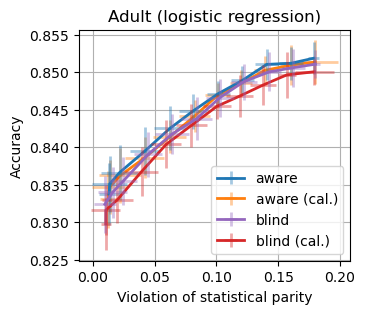

Results for attribute-aware setting:


accuracy            delta_sp          
           mean       std      mean       std
alpha                                        
inf    0.851870  0.002166  0.178678  0.004754
0.160  0.851201  0.002173  0.160333  0.009995
0.140  0.851051  0.002117  0.140767  0.009515
0.120  0.848922  0.001868  0.121103  0.009423
0.100  0.847161  0.001632  0.101662  0.009496
0.080  0.844813  0.002326  0.081012  0.011170
0.060  0.842506  0.002938  0.062412  0.012931
0.040  0.839489  0.003197  0.042196  0.012257
0.020  0.836623  0.003687  0.021739  0.014722
0.010  0.835108  0.003695  0.013742  0.013935
0.001  0.833784  0.004118  0.013178  0.008252

Results for attribute-aware setting with calibration:


accuracy            delta_sp          
           mean       std      mean       std
alpha                                        
inf    0.851379  0.002898  0.180196  0.018302
0.160  0.850956  0.002703  0.160643  0.009366
0.140  0.850273  0.001938  0.139694  0.008862
0.120  0.848539  0.001766  0.120045  0.009179
0.100  0.846915  0.001663  0.100966  0.010308
0.080  0.844144  0.002145  0.082373  0.012425
0.060  0.841387  0.002219  0.062316  0.013497
0.040  0.838616  0.002759  0.042241  0.015822
0.020  0.836227  0.003615  0.022287  0.017017
0.010  0.834657  0.003585  0.013619  0.013955
0.001  0.833033  0.003860  0.012761  0.006822

Results for attribute-blind setting:


accuracy            delta_sp          
           mean       std      mean       std
alpha                                        
inf    0.851078  0.001892  0.180177  0.003911
0.160  0.850628  0.002536  0.162415  0.009150
0.140  0.850055  0.002608  0.142830  0.009367
0.120  0.848758  0.002400  0.122294  0.010276
0.100  0.846615  0.002543  0.102838  0.011561
0.080  0.843817  0.002839  0.084089  0.012375
0.060  0.841714  0.002652  0.063881  0.013717
0.040  0.839039  0.002989  0.044775  0.011652
0.020  0.835504  0.003154  0.024772  0.011449
0.010  0.833989  0.003432  0.016087  0.011614
0.001  0.832391  0.003800  0.009823  0.008913

Results for attribute-blind setting with calibration:


accuracy            delta_sp          
           mean       std      mean       std
alpha                                        
inf    0.850068  0.001738  0.179332  0.015528
0.160  0.849659  0.003099  0.157147  0.007099
0.140  0.848307  0.002667  0.137947  0.010323
0.120  0.846833  0.002751  0.119063  0.010970
0.100  0.845468  0.001655  0.100568  0.011547
0.080  0.842902  0.002834  0.079780  0.012537
0.060  0.840390  0.003176  0.059474  0.012049
0.040  0.836759  0.003241  0.039564  0.013239
0.020  0.833006  0.003120  0.020044  0.012878
0.010  0.831600  0.003324  0.010606  0.011607
0.001  0.829771  0.003514  0.010568  0.004239

In [6]:
## Post-processing for statistical parity

df_aware = utils.postprocess_and_evaluate(
    [np.inf, 0.16, 0.14, 0.12, 0.1, 0.08, 0.06, 0.04, 0.02, 0.01, 0.001],
    seeds,
    'sp',
    ['accuracy', 'delta_sp'],
    print_code=True,
    **postprocess_kwargs,
)
df_aware_cal = utils.postprocess_and_evaluate(
    [np.inf, 0.16, 0.14, 0.12, 0.1, 0.08, 0.06, 0.04, 0.02, 0.01, 0.001],
    seeds,
    'sp',
    ['accuracy', 'delta_sp'],
    calibrator_factory=calibrator_factory,
    **postprocess_kwargs,
)
df_blind = utils.postprocess_and_evaluate(
    [np.inf, 0.16, 0.14, 0.12, 0.1, 0.08, 0.06, 0.04, 0.02, 0.01, 0.001],
    seeds,
    'sp',
    ['accuracy', 'delta_sp'],
    **postprocess_u_kwargs,
)
df_blind_cal = utils.postprocess_and_evaluate(
    [np.inf, 0.16, 0.14, 0.12, 0.1, 0.08, 0.06, 0.04, 0.02, 0.01, 0.001],
    seeds,
    'sp',
    ['accuracy', 'delta_sp'],
    calibrator_factory=calibrator_factory,
    **postprocess_u_kwargs,
)

fig, ax = plt.subplots(1, 1, figsize=(3.5, 3))
utils.plot_results(ax,
                   df_aware,
                   'delta_sp',
                   'accuracy',
                   label='aware',
                   zorder=20)
utils.plot_results(ax,
                   df_aware_cal,
                   'delta_sp',
                   'accuracy',
                   label='aware (cal.)',
                   zorder=10)
utils.plot_results(ax,
                   df_blind,
                   'delta_sp',
                   'accuracy',
                   label='blind',
                   color='tab:purple',
                   zorder=40)
utils.plot_results(ax,
                   df_blind_cal,
                   'delta_sp',
                   'accuracy',
                   label='blind (cal.)',
                   color='tab:red',
                   zorder=30)
ax.set_xlabel("Violation of statistical parity")
ax.set_ylabel("Accuracy")
ax.set_title("Adult (logistic regression)")
ax.legend()
plt.show()

print("Results for attribute-aware setting:")
display(df_aware)
print("Results for attribute-aware setting with calibration:")
display(df_aware_cal)
print("Results for attribute-blind setting:")
display(df_blind)
print("Results for attribute-blind setting with calibration:")
display(df_blind_cal)

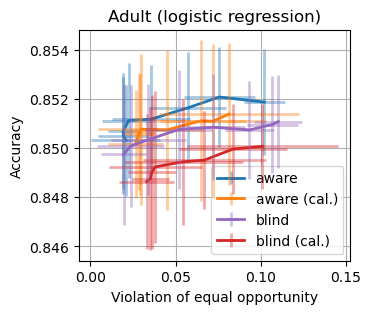

Results for attribute-aware setting:


accuracy           delta_eopp          
           mean       std       mean       std
alpha                                         
inf    0.851870  0.002166   0.101989  0.012120
0.100  0.852075  0.002032   0.075608  0.020899
0.080  0.851638  0.002262   0.057342  0.022201
0.060  0.851174  0.002200   0.035635  0.022835
0.040  0.851119  0.002356   0.022422  0.015420
0.020  0.850696  0.002372   0.019212  0.008892
0.010  0.850505  0.002384   0.019300  0.014899
0.001  0.850314  0.002246   0.020774  0.020191

Results for attribute-aware setting with calibration:


accuracy           delta_eopp          
           mean       std       mean       std
alpha                                         
inf    0.851379  0.002898   0.081340  0.041014
0.100  0.851092  0.003135   0.071920  0.030915
0.080  0.851106  0.003279   0.064772  0.026350
0.060  0.850737  0.003246   0.044960  0.021517
0.040  0.850764  0.003077   0.029750  0.025414
0.020  0.850573  0.002470   0.028894  0.008726
0.010  0.850655  0.002355   0.028696  0.008826
0.001  0.850164  0.002210   0.026454  0.016170

Results for attribute-blind setting:


accuracy           delta_eopp          
           mean       std       mean       std
alpha                                         
inf    0.851078  0.001892   0.110289  0.014067
0.100  0.850956  0.001975   0.106763  0.015044
0.080  0.850737  0.002003   0.093319  0.014245
0.060  0.850846  0.002150   0.072079  0.018759
0.040  0.850751  0.002418   0.051685  0.019562
0.020  0.850341  0.002255   0.034034  0.022282
0.010  0.850082  0.002497   0.023621  0.019728
0.001  0.849741  0.002855   0.019391  0.013272

Results for attribute-blind setting with calibration:


accuracy           delta_eopp          
           mean       std       mean       std
alpha                                         
inf    0.850068  0.001738   0.101008  0.044384
0.100  0.849959  0.001832   0.083716  0.031795
0.080  0.849509  0.001986   0.066847  0.035968
0.060  0.849440  0.002568   0.054387  0.034948
0.040  0.849236  0.003094   0.038069  0.027338
0.020  0.849017  0.003129   0.035989  0.014169
0.010  0.848758  0.002914   0.035240  0.011006
0.001  0.848635  0.002751   0.033004  0.016128

In [7]:
## Post-processing for equal opportunity

df_aware = utils.postprocess_and_evaluate(
    [np.inf, 0.1, 0.08, 0.06, 0.04, 0.02, 0.01, 0.001],
    seeds,
    'eopp',
    ['accuracy', 'delta_eopp'],
    **postprocess_kwargs,
)
df_aware_cal = utils.postprocess_and_evaluate(
    [np.inf, 0.1, 0.08, 0.06, 0.04, 0.02, 0.01, 0.001],
    seeds,
    'eopp',
    ['accuracy', 'delta_eopp'],
    calibrator_factory=calibrator_factory,
    **postprocess_kwargs,
)
df_blind = utils.postprocess_and_evaluate(
    [np.inf, 0.1, 0.08, 0.06, 0.04, 0.02, 0.01, 0.001],
    seeds,
    'eopp',
    ['accuracy', 'delta_eopp'],
    **postprocess_u_kwargs,
)
df_blind_cal = utils.postprocess_and_evaluate(
    [np.inf, 0.1, 0.08, 0.06, 0.04, 0.02, 0.01, 0.001],
    seeds,
    'eopp',
    ['accuracy', 'delta_eopp'],
    calibrator_factory=calibrator_factory,
    **postprocess_u_kwargs,
)

fig, ax = plt.subplots(1, 1, figsize=(3.5, 3))
utils.plot_results(ax,
                   df_aware,
                   'delta_eopp',
                   'accuracy',
                   label='aware',
                   zorder=10)
utils.plot_results(ax,
                   df_aware_cal,
                   'delta_eopp',
                   'accuracy',
                   label='aware (cal.)',
                   zorder=20)
utils.plot_results(ax,
                   df_blind,
                   'delta_eopp',
                   'accuracy',
                   label='blind',
                   color='tab:purple',
                   zorder=40)
utils.plot_results(ax,
                   df_blind_cal,
                   'delta_eopp',
                   'accuracy',
                   label='blind (cal.)',
                   color='tab:red',
                   zorder=30)
ax.set_xlabel("Violation of equal opportunity")
ax.set_ylabel("Accuracy")
ax.set_title("Adult (logistic regression)")
ax.legend()
plt.show()

print("Results for attribute-aware setting:")
display(df_aware)
print("Results for attribute-aware setting with calibration:")
display(df_aware_cal)
print("Results for attribute-blind setting:")
display(df_blind)
print("Results for attribute-blind setting with calibration:")
display(df_blind_cal)

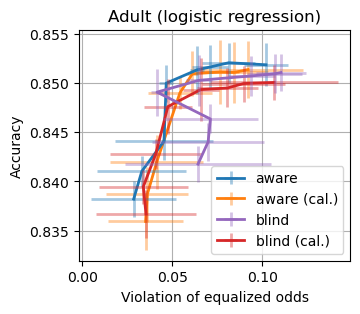

Results for attribute-aware setting:


accuracy            delta_eo          
           mean       std      mean       std
alpha                                        
inf    0.851870  0.002166  0.101989  0.012120
0.100  0.852075  0.002032  0.081294  0.014834
0.080  0.851638  0.002262  0.070771  0.009929
0.060  0.851351  0.002462  0.063690  0.004098
0.040  0.850000  0.001889  0.046551  0.004003
0.020  0.844103  0.001946  0.045315  0.026997
0.010  0.841032  0.001604  0.032989  0.024644
0.001  0.838206  0.001861  0.028472  0.023453

Results for attribute-aware setting with calibration:


accuracy            delta_eo          
           mean       std      mean       std
alpha                                        
inf    0.851379  0.002898  0.092035  0.030655
0.100  0.851092  0.003135  0.084274  0.019015
0.080  0.851133  0.003234  0.076660  0.010239
0.060  0.850956  0.002285  0.061122  0.003024
0.040  0.849004  0.001613  0.054151  0.017863
0.020  0.841974  0.002773  0.041273  0.025694
0.010  0.838698  0.002785  0.036062  0.022790
0.001  0.835927  0.002926  0.035078  0.020814

Results for attribute-blind setting:


accuracy            delta_eo          
           mean       std      mean       std
alpha                                        
inf    0.851078  0.001892  0.110289  0.014067
0.100  0.850956  0.001975  0.106763  0.015044
0.080  0.850737  0.002003  0.093916  0.013040
0.060  0.850287  0.002623  0.064747  0.007311
0.040  0.849085  0.002378  0.041436  0.003117
0.020  0.846355  0.001474  0.071108  0.026289
0.010  0.844021  0.001968  0.069838  0.031014
0.001  0.841769  0.001846  0.064232  0.040742

Results for attribute-blind setting with calibration:


accuracy            delta_eo          
           mean       std      mean       std
alpha                                        
inf    0.850068  0.001738  0.106449  0.035612
0.100  0.849959  0.001832  0.089555  0.022981
0.080  0.849509  0.001986  0.080599  0.017013
0.060  0.849345  0.003168  0.065716  0.010081
0.040  0.847611  0.002801  0.047463  0.013330
0.020  0.842820  0.001522  0.040785  0.025539
0.010  0.839462  0.001734  0.033830  0.024891
0.001  0.836705  0.002421  0.035292  0.027615

In [8]:
## Post-processing for equalized odds

df_aware = utils.postprocess_and_evaluate(
    [np.inf, 0.1, 0.08, 0.06, 0.04, 0.02, 0.01, 0.001],
    seeds,
    'eo',
    ['accuracy', 'delta_eo'],
    **postprocess_kwargs,
)
df_aware_cal = utils.postprocess_and_evaluate(
    [np.inf, 0.1, 0.08, 0.06, 0.04, 0.02, 0.01, 0.001],
    seeds,
    'eo',
    ['accuracy', 'delta_eo'],
    calibrator_factory=calibrator_factory,
    **postprocess_kwargs,
)
df_blind = utils.postprocess_and_evaluate(
    [np.inf, 0.1, 0.08, 0.06, 0.04, 0.02, 0.01, 0.001],
    seeds,
    'eo',
    ['accuracy', 'delta_eo'],
    **postprocess_u_kwargs,
)
df_blind_cal = utils.postprocess_and_evaluate(
    [np.inf, 0.1, 0.08, 0.06, 0.04, 0.02, 0.01, 0.001],
    seeds,
    'eo',
    ['accuracy', 'delta_eo'],
    calibrator_factory=calibrator_factory,
    **postprocess_u_kwargs,
)

fig, ax = plt.subplots(1, 1, figsize=(3.5, 3))
utils.plot_results(ax,
                   df_aware,
                   'delta_eo',
                   'accuracy',
                   label='aware',
                   zorder=20)
utils.plot_results(ax,
                   df_aware_cal,
                   'delta_eo',
                   'accuracy',
                   label='aware (cal.)',
                   zorder=10)
utils.plot_results(ax,
                   df_blind,
                   'delta_eo',
                   'accuracy',
                   label='blind',
                   color='tab:purple',
                   zorder=40)
utils.plot_results(ax,
                   df_blind_cal,
                   'delta_eo',
                   'accuracy',
                   label='blind (cal.)',
                   color='tab:red',
                   zorder=30)
ax.set_xlabel("Violation of equalized odds")
ax.set_ylabel("Accuracy")
ax.set_title("Adult (logistic regression)")
ax.legend()
plt.show()

print("Results for attribute-aware setting:")
display(df_aware)
print("Results for attribute-aware setting with calibration:")
display(df_aware_cal)
print("Results for attribute-blind setting:")
display(df_blind)
print("Results for attribute-blind setting with calibration:")
display(df_blind_cal)

## Gradient boosting decision tree

In [9]:
# Train attribute-aware p(Y | X) predictor
predictor_y = lightgbm.LGBMClassifier(random_state=seed_pretrain)
predictor_y.fit(inputs_pretrain, labels_pretrain)

# Train attribute-blind p(A, Y | X) predictor
predictor_u_ay = lightgbm.LGBMClassifier(random_state=seed_pretrain)
predictor_u_ay.fit(inputs_u_pretrain, labels_ay_pretrain)

print(
    'Binned ECE of attribute-blind predictor:',
    utils.calibration_error(predictor_u_ay.predict_proba(inputs_u_),
                            groups_ * n_classes + labels_,
                            n_bins=n_bins_calib))

Binned ECE of attribute-blind predictor: 0.3659383374419922


In [10]:
# Precompute P(A, Y | X) on (test + post-processing) set for aware setting
probas_y_ = predictor_y.predict_proba(inputs_).reshape(-1, n_classes)
probas_ay_ = np.einsum("ij,ik->ijk", np.eye(n_groups)[groups_], probas_y_)

# Precompute P(A, Y | X) on (test + post-processing) set for blind setting
probas_ay_u_ = predictor_u_ay.predict_proba(inputs_u_).reshape(
    -1, n_groups, n_classes)

postprocess_kwargs = {
    'n_test': n_test,
    'n_classes': n_classes,
    'n_groups': n_groups,
    'labels': labels_,
    'groups': groups_,
    'probas_ay': probas_ay_,
    'max_workers': max_workers,
}
postprocess_u_kwargs = {**postprocess_kwargs, 'probas_ay': probas_ay_u_}

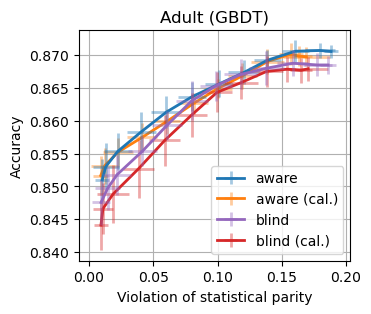

Results for attribute-aware setting:


accuracy            delta_sp          
           mean       std      mean       std
alpha                                        
inf    0.870530  0.001009  0.188283  0.005546
0.180  0.870680  0.001119  0.179737  0.011426
0.160  0.870571  0.001671  0.160559  0.010637
0.140  0.869206  0.001539  0.138895  0.010806
0.120  0.867349  0.001825  0.120649  0.012092
0.100  0.865602  0.002038  0.101343  0.010911
0.080  0.863650  0.002212  0.080166  0.011092
0.060  0.861302  0.002393  0.060123  0.011544
0.040  0.858327  0.003065  0.040732  0.011081
0.020  0.855337  0.002766  0.022369  0.011047
0.010  0.853003  0.003573  0.012977  0.010194
0.001  0.850996  0.003137  0.010325  0.005502

Results for attribute-aware setting with calibration:


accuracy            delta_sp          
           mean       std      mean       std
alpha                                        
inf    0.869711  0.001429  0.169060  0.018192
0.180  0.869833  0.001477  0.163064  0.010271
0.160  0.870134  0.001723  0.157101  0.009523
0.140  0.869001  0.001915  0.138792  0.012780
0.120  0.866830  0.001963  0.119342  0.011099
0.100  0.864892  0.001447  0.100277  0.010913
0.080  0.862640  0.001573  0.081438  0.010858
0.060  0.859910  0.001882  0.060747  0.010352
0.040  0.857453  0.002136  0.041238  0.011464
0.020  0.855228  0.002219  0.022583  0.011487
0.010  0.853167  0.002751  0.012241  0.010311
0.001  0.851665  0.002973  0.009127  0.005801

Results for attribute-blind setting:


accuracy            delta_sp          
           mean       std      mean       std
alpha                                        
inf    0.868482  0.001342  0.186011  0.005891
0.180  0.868482  0.001756  0.177621  0.011380
0.160  0.868741  0.001998  0.158669  0.011989
0.140  0.867977  0.002584  0.138017  0.013748
0.120  0.867035  0.002282  0.118060  0.012665
0.100  0.865315  0.002248  0.098820  0.012691
0.080  0.863049  0.002933  0.080065  0.012307
0.060  0.859337  0.002196  0.060813  0.011813
0.040  0.855364  0.002252  0.041569  0.011536
0.020  0.851802  0.003040  0.021879  0.011091
0.010  0.849700  0.003258  0.014438  0.009559
0.001  0.847570  0.003362  0.009398  0.006846

Results for attribute-blind setting with calibration:


accuracy            delta_sp          
           mean       std      mean       std
alpha                                        
inf    0.867895  0.001828  0.170470  0.015320
0.180  0.867663  0.001925  0.165011  0.008232
0.160  0.867841  0.001878  0.154398  0.005927
0.140  0.867499  0.002308  0.138243  0.012385
0.120  0.865779  0.002472  0.118154  0.013277
0.100  0.864305  0.003034  0.099550  0.011495
0.080  0.860865  0.003383  0.079878  0.012262
0.060  0.857016  0.003850  0.058983  0.012163
0.040  0.852716  0.004420  0.038654  0.012274
0.020  0.848853  0.004380  0.018769  0.012285
0.010  0.846628  0.003846  0.010843  0.008050
0.001  0.844130  0.003827  0.009311  0.005557

In [11]:
## Post-processing for statistical parity

df_aware = utils.postprocess_and_evaluate(
    [np.inf, 0.18, 0.16, 0.14, 0.12, 0.1, 0.08, 0.06, 0.04, 0.02, 0.01, 0.001],
    seeds,
    'sp',
    ['accuracy', 'delta_sp'],
    **postprocess_kwargs,
)
df_aware_cal = utils.postprocess_and_evaluate(
    [np.inf, 0.18, 0.16, 0.14, 0.12, 0.1, 0.08, 0.06, 0.04, 0.02, 0.01, 0.001],
    seeds,
    'sp',
    ['accuracy', 'delta_sp'],
    calibrator_factory=calibrator_factory,
    **postprocess_kwargs,
)
df_blind = utils.postprocess_and_evaluate(
    [np.inf, 0.18, 0.16, 0.14, 0.12, 0.1, 0.08, 0.06, 0.04, 0.02, 0.01, 0.001],
    seeds,
    'sp',
    ['accuracy', 'delta_sp'],
    **postprocess_u_kwargs,
)
df_blind_cal = utils.postprocess_and_evaluate(
    [np.inf, 0.18, 0.16, 0.14, 0.12, 0.1, 0.08, 0.06, 0.04, 0.02, 0.01, 0.001],
    seeds,
    'sp',
    ['accuracy', 'delta_sp'],
    calibrator_factory=calibrator_factory,
    **postprocess_u_kwargs,
)

fig, ax = plt.subplots(1, 1, figsize=(3.5, 3))
utils.plot_results(ax,
                   df_aware,
                   'delta_sp',
                   'accuracy',
                   label='aware',
                   zorder=20)
utils.plot_results(ax,
                   df_aware_cal,
                   'delta_sp',
                   'accuracy',
                   label='aware (cal.)',
                   zorder=10)
utils.plot_results(ax,
                   df_blind,
                   'delta_sp',
                   'accuracy',
                   label='blind',
                   color='tab:purple',
                   zorder=40)
utils.plot_results(ax,
                   df_blind_cal,
                   'delta_sp',
                   'accuracy',
                   label='blind (cal.)',
                   color='tab:red',
                   zorder=30)
ax.set_xlabel("Violation of statistical parity")
ax.set_ylabel("Accuracy")
ax.set_title("Adult (GBDT)")
ax.legend()
plt.show()

print("Results for attribute-aware setting:")
display(df_aware)
print("Results for attribute-aware setting with calibration:")
display(df_aware_cal)
print("Results for attribute-blind setting:")
display(df_blind)
print("Results for attribute-blind setting with calibration:")
display(df_blind_cal)

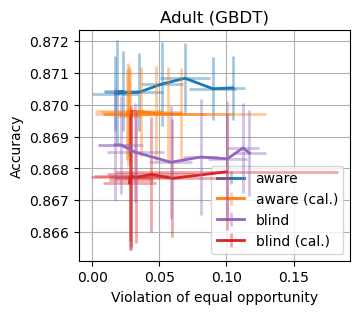

Results for attribute-aware setting:


accuracy           delta_eopp          
           mean       std       mean       std
alpha                                         
inf    0.870530  0.001009   0.104615  0.009519
0.100  0.870502  0.000984   0.089898  0.017433
0.080  0.870830  0.001105   0.069172  0.018765
0.060  0.870652  0.001319   0.052068  0.015627
0.040  0.870393  0.001228   0.034801  0.018176
0.020  0.870352  0.001177   0.017048  0.017009
0.010  0.870407  0.001618   0.018221  0.009491
0.001  0.870420  0.001251   0.022665  0.013958

Results for attribute-aware setting with calibration:


accuracy           delta_eopp          
           mean       std       mean       std
alpha                                         
inf    0.869711  0.001429   0.065783  0.063523
0.100  0.869711  0.001477   0.056176  0.048460
0.080  0.869724  0.001483   0.047616  0.037115
0.060  0.869779  0.001400   0.036677  0.030263
0.040  0.869806  0.001403   0.027335  0.025248
0.020  0.869683  0.001429   0.025971  0.004739
0.010  0.869642  0.001482   0.027922  0.008567
0.001  0.869697  0.001611   0.026654  0.018564

Results for attribute-blind setting:


accuracy           delta_eopp          
           mean       std       mean       std
alpha                                         
inf    0.868482  0.001342   0.117159  0.012465
0.100  0.868646  0.001411   0.112457  0.012107
0.080  0.868305  0.001823   0.100711  0.014380
0.060  0.868359  0.001817   0.080870  0.012869
0.040  0.868195  0.001777   0.058621  0.015974
0.020  0.868509  0.001546   0.032162  0.020941
0.010  0.868741  0.001547   0.021122  0.016821
0.001  0.868741  0.001771   0.016954  0.012524

Results for attribute-blind setting with calibration:


accuracy           delta_eopp          
           mean       std       mean       std
alpha                                         
inf    0.867895  0.001828   0.100171  0.083028
0.100  0.867690  0.001855   0.059768  0.043532
0.080  0.867813  0.001805   0.043983  0.032686
0.060  0.867718  0.002046   0.032894  0.033464
0.040  0.867759  0.002211   0.029074  0.027776
0.020  0.867636  0.002201   0.028693  0.016279
0.010  0.867731  0.002008   0.028001  0.015332
0.001  0.867540  0.002105   0.027800  0.019844

In [12]:
## Post-processing for equal opportunity

df_aware = utils.postprocess_and_evaluate(
    [np.inf, 0.1, 0.08, 0.06, 0.04, 0.02, 0.01, 0.001],
    seeds,
    'eopp',
    ['accuracy', 'delta_eopp'],
    **postprocess_kwargs,
)
df_aware_cal = utils.postprocess_and_evaluate(
    [np.inf, 0.1, 0.08, 0.06, 0.04, 0.02, 0.01, 0.001],
    seeds,
    'eopp',
    ['accuracy', 'delta_eopp'],
    calibrator_factory=calibrator_factory,
    **postprocess_kwargs,
)
df_blind = utils.postprocess_and_evaluate(
    [np.inf, 0.1, 0.08, 0.06, 0.04, 0.02, 0.01, 0.001],
    seeds,
    'eopp',
    ['accuracy', 'delta_eopp'],
    **postprocess_u_kwargs,
)
df_blind_cal = utils.postprocess_and_evaluate(
    [np.inf, 0.1, 0.08, 0.06, 0.04, 0.02, 0.01, 0.001],
    seeds,
    'eopp',
    ['accuracy', 'delta_eopp'],
    calibrator_factory=calibrator_factory,
    **postprocess_u_kwargs,
)

fig, ax = plt.subplots(1, 1, figsize=(3.5, 3))
utils.plot_results(ax,
                   df_aware,
                   'delta_eopp',
                   'accuracy',
                   label='aware',
                   zorder=10)
utils.plot_results(ax,
                   df_aware_cal,
                   'delta_eopp',
                   'accuracy',
                   label='aware (cal.)',
                   zorder=20)
utils.plot_results(ax,
                   df_blind,
                   'delta_eopp',
                   'accuracy',
                   label='blind',
                   color='tab:purple',
                   zorder=40)
utils.plot_results(ax,
                   df_blind_cal,
                   'delta_eopp',
                   'accuracy',
                   label='blind (cal.)',
                   color='tab:red',
                   zorder=30)
ax.set_xlabel("Violation of equal opportunity")
ax.set_ylabel("Accuracy")
ax.set_title("Adult (GBDT)")
ax.legend()
plt.show()

print("Results for attribute-aware setting:")
display(df_aware)
print("Results for attribute-aware setting with calibration:")
display(df_aware_cal)
print("Results for attribute-blind setting:")
display(df_blind)
print("Results for attribute-blind setting with calibration:")
display(df_blind_cal)

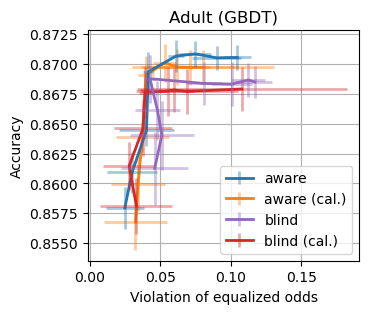

Results for attribute-aware setting:


accuracy            delta_eo          
           mean       std      mean       std
alpha                                        
inf    0.870530  0.001009  0.104615  0.009519
0.100  0.870502  0.000984  0.089933  0.017383
0.080  0.870830  0.001105  0.074900  0.011276
0.060  0.870652  0.001319  0.061289  0.005792
0.040  0.869342  0.001671  0.041563  0.004109
0.020  0.864442  0.001304  0.040215  0.019261
0.010  0.860920  0.001690  0.029978  0.017481
0.001  0.857958  0.001741  0.024858  0.013341

Results for attribute-aware setting with calibration:


accuracy            delta_eo          
           mean       std      mean       std
alpha                                        
inf    0.869711  0.001429  0.080391  0.050269
0.100  0.869711  0.001477  0.070784  0.034510
0.080  0.869724  0.001483  0.062223  0.023081
0.060  0.870079  0.001569  0.053081  0.008066
0.040  0.869055  0.001638  0.039898  0.005771
0.020  0.863882  0.001244  0.037281  0.019029
0.010  0.859924  0.002269  0.034257  0.019065
0.001  0.856770  0.002358  0.032405  0.022612

Results for attribute-blind setting:


accuracy            delta_eo          
           mean       std      mean       std
alpha                                        
inf    0.868482  0.001342  0.117159  0.012465
0.100  0.868646  0.001411  0.112457  0.012107
0.080  0.868305  0.001823  0.100711  0.014380
0.060  0.868359  0.001817  0.080870  0.012869
0.040  0.868755  0.002008  0.042682  0.003948
0.020  0.866121  0.002482  0.047997  0.015898
0.010  0.864032  0.002882  0.051144  0.022786
0.001  0.861261  0.003035  0.046041  0.023802

Results for attribute-blind setting with calibration:


accuracy            delta_eo          
           mean       std      mean       std
alpha                                        
inf    0.867895  0.001828  0.107871  0.074647
0.100  0.867690  0.001855  0.069096  0.036008
0.080  0.867813  0.001805  0.059647  0.023821
0.060  0.867718  0.002046  0.055250  0.018961
0.040  0.867595  0.002111  0.039172  0.003961
0.020  0.864619  0.002367  0.037830  0.020477
0.010  0.861452  0.001994  0.027895  0.018344
0.001  0.858122  0.002314  0.033057  0.025584

In [13]:
## Post-processing for equalized odds

df_aware = utils.postprocess_and_evaluate(
    [np.inf, 0.1, 0.08, 0.06, 0.04, 0.02, 0.01, 0.001],
    seeds,
    'eo',
    ['accuracy', 'delta_eo'],
    **postprocess_kwargs,
)
df_aware_cal = utils.postprocess_and_evaluate(
    [np.inf, 0.1, 0.08, 0.06, 0.04, 0.02, 0.01, 0.001],
    seeds,
    'eo',
    ['accuracy', 'delta_eo'],
    calibrator_factory=calibrator_factory,
    **postprocess_kwargs,
)
df_blind = utils.postprocess_and_evaluate(
    [np.inf, 0.1, 0.08, 0.06, 0.04, 0.02, 0.01, 0.001],
    seeds,
    'eo',
    ['accuracy', 'delta_eo'],
    **postprocess_u_kwargs,
)
df_blind_cal = utils.postprocess_and_evaluate(
    [np.inf, 0.1, 0.08, 0.06, 0.04, 0.02, 0.01, 0.001],
    seeds,
    'eo',
    ['accuracy', 'delta_eo'],
    calibrator_factory=calibrator_factory,
    **postprocess_u_kwargs,
)

fig, ax = plt.subplots(1, 1, figsize=(3.5, 3))
utils.plot_results(ax,
                   df_aware,
                   'delta_eo',
                   'accuracy',
                   label='aware',
                   zorder=20)
utils.plot_results(ax,
                   df_aware_cal,
                   'delta_eo',
                   'accuracy',
                   label='aware (cal.)',
                   zorder=10)
utils.plot_results(ax,
                   df_blind,
                   'delta_eo',
                   'accuracy',
                   label='blind',
                   color='tab:purple',
                   zorder=40)
utils.plot_results(ax,
                   df_blind_cal,
                   'delta_eo',
                   'accuracy',
                   label='blind (cal.)',
                   color='tab:red',
                   zorder=30)
ax.set_xlabel("Violation of equalized odds")
ax.set_ylabel("Accuracy")
ax.set_title("Adult (GBDT)")
ax.legend()
plt.show()

print("Results for attribute-aware setting:")
display(df_aware)
print("Results for attribute-aware setting with calibration:")
display(df_aware_cal)
print("Results for attribute-blind setting:")
display(df_blind)
print("Results for attribute-blind setting with calibration:")
display(df_blind_cal)